# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OneHotEncoder,RobustScaler
import time


In [2]:
pd.options.display.float_format = '{:,.2f}'.format

Обзор датасета

Признаки
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак
* Price — цена (евро)

Загрузка данных

In [3]:
df_cars = pd.read_csv('/datasets/autos.csv')

Обзор датафрейма

In [4]:
df_cars.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Просмотр общей информации

In [5]:
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

* Датасет состоит из категориальных и вещественных признаков
* При предварительном просмотре бросается в глаза нулевая мощьность 
* Присутствуют пропуски

Приведение названий признаков к змеиному регистру

In [6]:
df_cars = df_cars.rename(columns = {'DateCrawled': 'date_crawled','Price' :'price','VehicleType':'vehicle_type',
                                    'RegistrationYear':'registration_year','Gearbox':'gear_box','Power':'power',
                                    'Model' : 'model', 'Kilometer' : 'kilometer','RegistrationMonth':'registration_month',
                                    'FuelType' : 'fuel_type','Brand' : 'brand','Repaired': 'repaired','DateCreated' : 'date_created',
                                    'NumberOfPictures' : 'number_of_pictures','PostalCode':'postal_code','LastSeen' : 'last_seen'
                                   })

Доля пропусков

In [7]:
df_cars.isna().sum().to_frame().rename(columns = {0:'space'}).query('space>0')/len(df_cars)*100

,space
vehicle_type,10.58
gear_box,5.60
model,5.56
fuel_type,9.28
repaired,20.08


Просмотр стастистик 

In [8]:
df_cars.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,"354,369.00","354,369.00","354,369.00","354,369.00","354,369.00","354,369.00","354,369.00"
mean,"4,416.66","2,004.23",110.09,"128,211.17",5.71,0.00,"50,508.69"
std,"4,514.16",90.23,189.85,"37,905.34",3.73,0.00,"25,783.10"
min,0.00,"1,000.00",0.00,"5,000.00",0.00,0.00,"1,067.00"
25%,"1,050.00","1,999.00",69.00,"125,000.00",3.00,0.00,"30,165.00"
50%,"2,700.00","2,003.00",105.00,"150,000.00",6.00,0.00,"49,413.00"
75%,"6,400.00","2,008.00",143.00,"150,000.00",9.00,0.00,"71,083.00"
max,"20,000.00","9,999.00","20,000.00","150,000.00",12.00,0.00,"99,998.00"


Присутствуют аномалии
* Нулевая цена
* Невозможные значения годов регистрации
* Нулевая мощность
* Неправдоподобная мощность 
* Нулевой месяц регистрации
* Все машины имеют ноль картинок

**Обзор категориальных признаков**

Тип кузова

<AxesSubplot:title={'center':'Тип автомобильного кузова'}, ylabel='vehicle_type'>

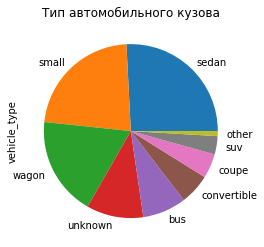

In [9]:
df_cars['vehicle_type'].fillna('unknown').value_counts().plot(kind = 'pie',title = 'Тип автомобильного кузова')

Тип коробки передач

In [10]:
# доля в процентах
(df_cars['gear_box'].fillna('unknown').value_counts() / len(df_cars) *100)

manual    75.70
auto      18.71
unknown    5.60
Name: gear_box, dtype: float64

Модель

In [11]:
# доля в процентах
(df_cars['model'].fillna('unknown').value_counts() / len(df_cars) *100)[:10]

golf       8.25
other      6.89
3er        5.58
unknown    5.56
polo       3.69
corsa      3.55
astra      3.05
passat     2.86
a4         2.79
c_klasse   2.35
Name: model, dtype: float64

Вид топлива

In [12]:
# в процентах
df_cars['fuel_type'].fillna('unknown').value_counts() / len(df_cars) *100

petrol     61.05
gasoline   27.86
unknown     9.28
lpg         1.50
cng         0.16
hybrid      0.07
other       0.06
electric    0.03
Name: fuel_type, dtype: float64

Была машина в ремонте или нет

In [13]:
df_cars['repaired'].fillna('unknown').value_counts() / len(df_cars) *100

no        69.75
unknown   20.08
yes       10.17
Name: repaired, dtype: float64

**Обработка аномалий**

Цена

Удаление всего что меньше 500 евро

In [14]:
df_cars = df_cars.query('price > 500')

Мощность

Удаление машин с неправдоподобными значениями 

In [15]:
df_cars = df_cars.query('power> 50 and power < 1000')


In [16]:

pd.options.mode.chained_assignment = None

list_models  = df_cars['model'].unique() 
# df = df_cars.copy()
for model in list_models:
    
    index_model_power_zero =  df_cars.query('model == @model & power == 0 ').index
    mean_power_of_model = df_cars.query('model == @model & power != 0 ')['power'].mean()
#     ser = df['power'].loc[ind].copy()
#     ser = mean_power_of_model
    df_cars['power'].loc[index_model_power_zero] = mean_power_of_model
#     print(mean_power_of_model,model)

Год регистрации

Удаление машин у которых год регистрации меньше года выгрузки анкеты

In [17]:
year_date_crawled = pd.to_datetime(df_cars['date_crawled'], format='%Y-%m-%d %H:%M:%S').dt.year
compare_registration_year = year_date_crawled < df_cars['registration_year']
index_error = compare_registration_year[compare_registration_year == True].index


In [18]:
df_cars = df_cars.drop(index = index_error)

In [19]:
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267937 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   date_crawled        267937 non-null  object 
 1   price               267937 non-null  int64  
 2   vehicle_type        260097 non-null  object 
 3   registration_year   267937 non-null  int64  
 4   gear_box            263935 non-null  object 
 5   power               267937 non-null  float64
 6   model               258974 non-null  object 
 7   kilometer           267937 non-null  int64  
 8   registration_month  267937 non-null  int64  
 9   fuel_type           256174 non-null  object 
 10  brand               267937 non-null  object 
 11  repaired            233477 non-null  object 
 12  date_created        267937 non-null  object 
 13  number_of_pictures  267937 non-null  int64  
 14  postal_code         267937 non-null  int64  
 15  last_seen           267937 non-nul

<AxesSubplot:title={'center':'Количество представленных автомобилей по годам'}>

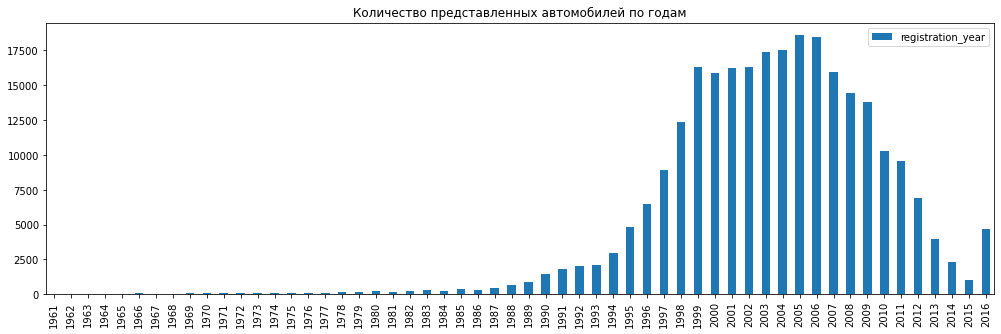

In [20]:
df_cars.query('registration_year > 1960 & registration_year < 2020')['registration_year'] \
    .value_counts() \
    .to_frame() \
    .sort_index() \
    .plot(kind = 'bar',figsize = (17,5), title = 'Количество представленных автомобилей по годам')

Возьмем временной промежуток с 1960 до 2016 включительно

In [21]:
df_cars = df_cars.query(' registration_year >= 1965 & registration_year <= 2016')

Удаление машин у которых год регистрации меньше года выгрузки анкеты

Месяц регистрации

<AxesSubplot:title={'center':'Доля в процентах регистраций каждого месяца'}>

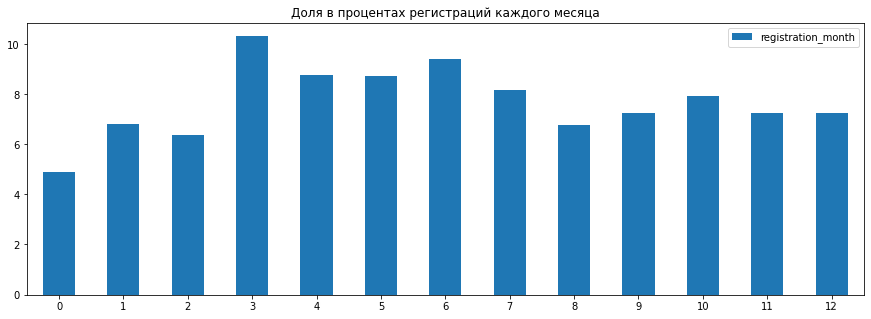

In [22]:
(df_cars['registration_month'].fillna('unknown').value_counts() / len(df_cars) *100) \
    .to_frame() \
    .sort_index() \
    .plot(kind = 'bar', title = 'Доля в процентах регистраций каждого месяца',figsize =(15,5),rot = 1)

Требуется уточнение что такое нулевой месяц, возможно неустановленный месяц  

**Обработка дубликатов**

Поиск дубликатов по важным признакам

In [23]:
most_important_columns = ['price','vehicle_type','registration_year','gear_box','power','kilometer',
                          'model','brand','repaired','postal_code','fuel_type']

In [24]:
df_cars[most_important_columns].duplicated().sum()

19186

Удаление дубликатов

In [25]:
df_cars = df_cars.drop_duplicates(subset=most_important_columns)

**Обработка пропусков**

In [26]:
df_cars.isna().sum().to_frame().rename(columns = {0:'space'}).query('space>0')/len(df_cars)*100

,space
vehicle_type,3.06
gear_box,1.57
model,3.44
fuel_type,4.61
repaired,13.23


Заполнение пропусков заклушкой в категории где  больше 10% пропусков

In [27]:
df_cars['repaired'] = df_cars['repaired'].fillna('unknown')

Размер датасета позволяет удалить  остальные пропуски

In [28]:
df_cars = df_cars.dropna()

In [29]:
df_cars.shape[0]

224128

Сброс всех индексов

In [30]:
df_cars.reset_index(drop = True, inplace= True )

**Корреляции на  основных влияющих факторах цены** 

In [31]:
df_cars[['price','power','kilometer','registration_year']].corr(method = 'spearman')

,price,power,kilometer,registration_year
price,1.00,0.48,-0.39,0.72
power,0.48,1.00,0.16,0.12
kilometer,-0.39,0.16,1.00,-0.45
registration_year,0.72,0.12,-0.45,1.00


Ожидаемая
* положительная корреляция между ценой и мощностью, а также годом регистрации
* отрицательная корреляция между ценой и пробегом

Просмотр статистик на обработанном датасете основных признаков влияющих на цену

In [32]:
df_cars[['price','power','kilometer','registration_year']].describe()

,price,power,kilometer,registration_year
count,"224,128.00","224,128.00","224,128.00","224,128.00"
mean,"5,415.74",126.10,"127,401.84","2,003.31"
std,"4,659.72",53.31,"36,889.40",5.81
min,501.00,51.00,"5,000.00","1,965.00"
25%,"1,790.00",88.00,"125,000.00","2,000.00"
50%,"3,800.00",116.00,"150,000.00","2,004.00"
75%,"7,800.00",150.00,"150,000.00","2,007.00"
max,"20,000.00",999.00,"150,000.00","2,016.00"


Датасет очищен от аномалий (странные значений цены, года регистрации, мощности)

## Обучение моделей

**Разбиение на целевые и тренировочные признаки**

In [33]:
features = df_cars.drop(['price','date_crawled','registration_month',
                         'date_created','number_of_pictures','postal_code','last_seen'], axis = 1)  
target = df_cars['price'] 



**Выделение категориальных признаков**

In [34]:
categories = []
for feature in features.columns:
    if features[feature].dtype == 'O':
        features[feature] = features[feature].astype('category')
        categories.append(feature) 
    else:
        features[feature] = features[feature].astype('int')
        

**Разбиение на тестовую и тренировочную  выборку**

In [35]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, 
                                                                            random_state=12345)

**Catboost**

In [36]:
params = {
#             'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3],
             'depth':[6,8]
            }

grid_cat = GridSearchCV(CatBoostRegressor(random_state = 12345,cat_features  = categories), 
            params, cv=3,scoring='neg_mean_squared_error')

In [37]:
%%time
grid_cat.fit(features_train,target_train,cat_features=categories)

Learning rate set to 0.086297
0:	learn: 4382.3407967	total: 215ms	remaining: 3m 35s
1:	learn: 4136.5677991	total: 383ms	remaining: 3m 10s
2:	learn: 3915.0304506	total: 543ms	remaining: 3m
3:	learn: 3720.5378095	total: 675ms	remaining: 2m 48s
4:	learn: 3538.7923639	total: 802ms	remaining: 2m 39s
5:	learn: 3376.4508736	total: 907ms	remaining: 2m 30s
6:	learn: 3233.6910582	total: 1.08s	remaining: 2m 33s
7:	learn: 3105.7115179	total: 1.2s	remaining: 2m 28s
8:	learn: 2984.8595326	total: 1.32s	remaining: 2m 25s
9:	learn: 2882.5401616	total: 1.45s	remaining: 2m 23s
10:	learn: 2786.4273243	total: 1.6s	remaining: 2m 23s
11:	learn: 2698.7516772	total: 1.73s	remaining: 2m 22s
12:	learn: 2624.2356411	total: 1.83s	remaining: 2m 18s
13:	learn: 2555.3543042	total: 1.96s	remaining: 2m 17s
14:	learn: 2490.8807831	total: 2.07s	remaining: 2m 15s
15:	learn: 2432.7365514	total: 2.21s	remaining: 2m 16s
16:	learn: 2382.6953795	total: 2.31s	remaining: 2m 13s
17:	learn: 2327.1555051	total: 2.42s	remaining: 2m 

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f72c25750d0>,
             param_grid={'depth': [6, 8]}, scoring='neg_mean_squared_error')

**LGBMRegressor**

In [38]:


parameters = {
#     'n_estimators': [50,100],
    'max_depth': [5,10]
   
}

grid_lgbm = GridSearchCV(LGBMRegressor(), parameters, cv=3, scoring='neg_mean_squared_error')


In [39]:
%%time
grid_lgbm.fit(features_train, target_train)

CPU times: user 13min 57s, sys: 4.38 s, total: 14min 1s
Wall time: 14min 8s


GridSearchCV(cv=3, estimator=LGBMRegressor(), param_grid={'max_depth': [5, 10]},
             scoring='neg_mean_squared_error')

**LinearRegression**

Кодирование признаков

In [40]:
oh = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

ar_tr = oh.fit_transform(features_train[categories])
ar_ts = oh.transform(features_test[categories])

X_tr = pd.DataFrame(ar_tr,columns = oh.get_feature_names(categories),index = features_train.index)
X_ts = pd.DataFrame(ar_ts,columns = oh.get_feature_names(categories),index = features_test.index)

features_train_linreg = pd.concat((features_train.drop(categories,axis = 1), X_tr), axis = 1)
features_test_linreg = pd.concat((features_test.drop(categories,axis = 1),X_ts), axis = 1)

Масштабирование

In [41]:
sr = RobustScaler()

num_cols = features_train_linreg.drop(X_tr.columns,axis = 1).columns

features_train_linreg.reset_index(drop = True,inplace = True)
features_test_linreg.reset_index(drop = True,inplace = True)

features_train_linreg.reset_index(drop = True,inplace = True)
features_test_linreg.reset_index(drop = True,inplace = True)

features_train_linreg[num_cols] = pd.DataFrame(sr.fit_transform(features_train_linreg[num_cols]), 
                                               columns = features_train_linreg[num_cols].columns)
features_test_linreg[num_cols] = pd.DataFrame(sr.transform(features_test_linreg[num_cols]),
                                              columns = features_test_linreg[num_cols].columns)

Поиск лучшей модели LinearRegression

In [42]:
param =  {'fit_intercept':[True,False]}

grid_linreg = GridSearchCV(LinearRegression(), param, cv=3,scoring='neg_mean_squared_error')

In [43]:
%%time
grid_linreg.fit(features_train_linreg,target_train)

CPU times: user 54.5 s, sys: 24.2 s, total: 1min 18s
Wall time: 1min 19s


GridSearchCV(cv=3, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]},
             scoring='neg_mean_squared_error')

Обучено 3 модели, две из которых применяют бустинг

## Анализ моделей

Измерение времени обучения и предсказания на полученных  моделях

In [44]:
# список трех обученных моделей
# list_models = [cat,lgbm,lin_reg]
list_models = [grid_cat,grid_lgbm, grid_linreg]

# списки признаков с OHE и без
features_trains = [features_train, features_train, features_train_linreg]

predictions_models = []
rmse = []
train_time = []
predictions_time = []

# получение списков времени тренировки моделей, времени предсказания, rmse
for model, i in zip(list_models, range(len(features_trains))) :
    
    start = time.time()
    model.best_estimator_.fit(features_trains[i],target_train)
    train_time.append(time.time() - start) 
    
    start = time.time()
    predictions_models.append(model.best_estimator_.predict(features_trains[i]))
    predictions_time.append(time.time() - start)
    
    if model != grid_linreg: 
        rmse.append((model.best_score_*-1)**0.5)
    else:
        rmse.append(mean_squared_error(target_train,predictions_models[i])**0.5)

Learning rate set to 0.092006
0:	learn: 4355.1780806	total: 392ms	remaining: 6m 31s
1:	learn: 4073.1903761	total: 677ms	remaining: 5m 37s
2:	learn: 3824.0818666	total: 942ms	remaining: 5m 13s
3:	learn: 3605.7512317	total: 1.17s	remaining: 4m 50s
4:	learn: 3409.3783627	total: 1.51s	remaining: 4m 59s
5:	learn: 3235.3572467	total: 1.76s	remaining: 4m 51s
6:	learn: 3081.5164240	total: 2.03s	remaining: 4m 48s
7:	learn: 2942.7495066	total: 2.29s	remaining: 4m 43s
8:	learn: 2820.3572303	total: 2.55s	remaining: 4m 41s
9:	learn: 2711.4377815	total: 2.79s	remaining: 4m 36s
10:	learn: 2613.7655744	total: 3.03s	remaining: 4m 32s
11:	learn: 2524.3724149	total: 3.22s	remaining: 4m 25s
12:	learn: 2445.9030206	total: 3.48s	remaining: 4m 24s
13:	learn: 2380.6177442	total: 3.69s	remaining: 4m 20s
14:	learn: 2319.2522438	total: 3.92s	remaining: 4m 17s
15:	learn: 2262.9623233	total: 4.13s	remaining: 4m 13s
16:	learn: 2216.2210566	total: 4.38s	remaining: 4m 13s
17:	learn: 2174.2908804	total: 4.64s	remainin

Сводные данные о времени обучения, прогнозирования, а также метрика RMSE

In [45]:
df_characters_models = pd.DataFrame({'time_of_train, sec': train_time,'time_of_prediction, sec': predictions_time,
                                    'rmse, €' : rmse
                                    },
                                    index = ['LGBM','CatBoost','LinearRegression'])
df_characters_models

,"time_of_train, sec","time_of_prediction, sec","rmse, €"
LGBM,212.10,1.90,"1,547.42"
CatBoost,355.80,1.82,"1,582.58"
LinearRegression,23.18,0.20,"2,469.50"


Два из трех показателей является лучшими у модели LGBMRegressor, также важнейшая метрика является немного выше. По этой причине LGBMRegressor можно считать лучшей

**Итоговое тестирование выбранной модели**

In [46]:
predictions = grid_lgbm.best_estimator_.predict(features_test)
rmse_best_model = mean_squared_error(target_test,predictions)**0.5
print('Метрика качества rmse  на тесте в €:',rmse_best_model)

Метрика качества rmse  на тесте в €: 1573.3919610023606


**Проверка адекватности**

In [47]:
dummy_reg = DummyRegressor(strategy = 'mean')

dummy_reg.fit(features_train,target_train) 
dummy_predictions = dummy_reg.predict(features_test)
rmse_dummy = mean_squared_error(target_test,dummy_predictions)**0.5

print('Метрика rmse для константной модели в €:', rmse_dummy)

Метрика rmse для константной модели в €: 4659.043762239551


Вывод:

    Найдена лучшая модель, которая соответствует требованиям метрики RMSE 